In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
#                                             torchvision.transforms.Normalize(mean=(0.5071, 0.4865, 0.4409), 
#                                             std=(0.2648, 0.2542, 0.2733))])

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
#                                             torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

cifar_dset_train = torchvision.datasets.CIFAR100('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR100('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# activation = hard_sigmoid
# # architecture = [int(32*32*3), 500, 10]
# architecture = [int(32*32*3), 2500, 500, 100]

# x,y = next(iter(train_loader))
# x = x.view(x.size(0),-1).to(device).T
# y_one_hot = F.one_hot(y, 100).to(device).T

# beta = 0.2
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.4, 0.25, 0.2]), 'fb': np.array([np.nan, 0.22, 0.11])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False


# activation = hard_sigmoid
# # architecture = [int(32*32*3), 500, 10]
# architecture = [int(32*32*3), 2000,  100]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.1, 0.08]), 'fb': np.array([np.nan, 0.02])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "divide_by_slow_loop_index"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 50
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False


### The Below hyperparams reaches to Epoch : 7, (top (1, 5)) Train Accuracy : [0.1252  0.27034], Test Accuracy : [0.1165 0.2551], Epoch : 9, (top (1, 5)) Train Accuracy : [0.14868 0.3013 ], Test Accuracy : [0.1363 0.2833]
# activation = hard_sigmoid
# architecture = [int(32*32*3), 2000, 1000, 100]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start =  {'ff' : np.array([0.15, 0.12, 0.07]), 'fb': np.array([np.nan, 0.05, 0.03])}

# neural_lr_start = 0.04
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 20
# neural_dynamic_iterations_free = 50
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False


activation = hard_sigmoid
architecture = [int(32*32*3), 2000, 1000, 100]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start =  {'ff' : np.array([0.16, 0.13, 0.08]), 'fb': np.array([np.nan, 0.06, 0.04])}

neural_lr_start = 0.06
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 20
neural_dynamic_iterations_free = 50
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
# _ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
#                                           neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                           neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

In [6]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 50
lr = lr_start
for epoch_ in range(n_epochs):
    if epoch_ < 20:
        lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 100).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield_topk( model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, topk = (1,5), printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield_topk( model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, topk = (1, 5), printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, (top {}) Train Accuracy : {}, Test Accuracy : {}".format( epoch_+1,(1,5), trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

2500it [04:18,  9.66it/s]
0it [00:00, ?it/s]

Epoch : 1, (top (1, 5)) Train Accuracy : [0.03582 0.11042], Test Accuracy : [0.0354 0.1049]
Free Information ratio: [0.49141014 0.02796377]
Nudged Information ratio: [0.49141023 0.02796373]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 2, (top (1, 5)) Train Accuracy : [0.05852 0.16064], Test Accuracy : [0.0561 0.1602]
Free Information ratio: [0.53715104 0.04294404]
Nudged Information ratio: [0.53715114 0.04294397]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 3, (top (1, 5)) Train Accuracy : [0.0779  0.18434], Test Accuracy : [0.0762 0.1794]
Free Information ratio: [0.59552064 0.05321768]
Nudged Information ratio: [0.59552064 0.05321755]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 4, (top (1, 5)) Train Accuracy : [0.09194 0.21548], Test Accuracy : [0.0828 0.2059]
Free Information ratio: [0.67832134 0.06655728]
Nudged Information ratio: [0.67832126 0.06655709]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 5, (top (1, 5)) Train Accuracy : [0.10452 0.23564], Test Accuracy : [0.0944 0.2262]
Free Information ratio: [0.68065983 0.06767387]
Nudged Information ratio: [0.68065958 0.0676736 ]


2500it [04:19,  9.63it/s]
0it [00:00, ?it/s]

Epoch : 6, (top (1, 5)) Train Accuracy : [0.11842 0.26212], Test Accuracy : [0.109  0.2471]
Free Information ratio: [0.7803231  0.08142731]
Nudged Information ratio: [0.7803229  0.08142702]


2500it [04:19,  9.64it/s]
0it [00:00, ?it/s]

Epoch : 7, (top (1, 5)) Train Accuracy : [0.13414 0.27994], Test Accuracy : [0.1198 0.2582]
Free Information ratio: [0.78247603 0.08678753]
Nudged Information ratio: [0.78247561 0.08678712]


2500it [04:19,  9.64it/s]
0it [00:00, ?it/s]

Epoch : 8, (top (1, 5)) Train Accuracy : [0.14856 0.30006], Test Accuracy : [0.1322 0.2753]
Free Information ratio: [0.83327643 0.09126887]
Nudged Information ratio: [0.83327587 0.09126839]


2500it [04:19,  9.63it/s]
0it [00:00, ?it/s]

Epoch : 9, (top (1, 5)) Train Accuracy : [0.16012 0.3144 ], Test Accuracy : [0.1432 0.2952]
Free Information ratio: [0.80797452 0.08654642]
Nudged Information ratio: [0.80797392 0.08654587]


2500it [04:19,  9.63it/s]
0it [00:00, ?it/s]

Epoch : 10, (top (1, 5)) Train Accuracy : [0.16844 0.32118], Test Accuracy : [0.1464 0.297 ]
Free Information ratio: [0.9472003  0.10963241]
Nudged Information ratio: [0.94719959 0.10963185]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 11, (top (1, 5)) Train Accuracy : [0.17614 0.33122], Test Accuracy : [0.1516 0.3033]
Free Information ratio: [0.86294278 0.1031989 ]
Nudged Information ratio: [0.86294185 0.10319813]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 12, (top (1, 5)) Train Accuracy : [0.1868 0.3473], Test Accuracy : [0.156 0.317]
Free Information ratio: [0.85497915 0.09726416]
Nudged Information ratio: [0.85497807 0.0972633 ]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 13, (top (1, 5)) Train Accuracy : [0.19146 0.3573 ], Test Accuracy : [0.1617 0.3259]
Free Information ratio: [0.95852491 0.11498125]
Nudged Information ratio: [0.95852372 0.11498025]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 14, (top (1, 5)) Train Accuracy : [0.20132 0.3622 ], Test Accuracy : [0.1716 0.33  ]
Free Information ratio: [0.92046303 0.10840224]
Nudged Information ratio: [0.92046188 0.10840118]


2500it [04:31,  9.20it/s]
0it [00:00, ?it/s]

Epoch : 15, (top (1, 5)) Train Accuracy : [0.20666 0.37338], Test Accuracy : [0.1741 0.337 ]
Free Information ratio: [0.97130478 0.11919089]
Nudged Information ratio: [0.97130362 0.11918985]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 16, (top (1, 5)) Train Accuracy : [0.21798 0.37108], Test Accuracy : [0.1827 0.3402]
Free Information ratio: [1.04854301 0.13113598]
Nudged Information ratio: [1.04854184 0.1311349 ]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 17, (top (1, 5)) Train Accuracy : [0.22184 0.37554], Test Accuracy : [0.1869 0.3418]
Free Information ratio: [0.97255353 0.1180665 ]
Nudged Information ratio: [0.97255221 0.11806526]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 18, (top (1, 5)) Train Accuracy : [0.22336 0.38708], Test Accuracy : [0.1836 0.349 ]
Free Information ratio: [0.93235753 0.11839073]
Nudged Information ratio: [0.9323561  0.11838947]


2500it [04:21,  9.56it/s]
0it [00:00, ?it/s]

Epoch : 19, (top (1, 5)) Train Accuracy : [0.2291 0.392 ], Test Accuracy : [0.1884 0.3481]
Free Information ratio: [0.9572057  0.11624499]
Nudged Information ratio: [0.95720427 0.11624363]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 20, (top (1, 5)) Train Accuracy : [0.23744 0.39846], Test Accuracy : [0.1951 0.3546]
Free Information ratio: [0.97461091 0.12115503]
Nudged Information ratio: [0.97460922 0.12115347]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 21, (top (1, 5)) Train Accuracy : [0.25256 0.41304], Test Accuracy : [0.2047 0.3698]
Free Information ratio: [0.91814682 0.10789619]
Nudged Information ratio: [0.91814514 0.10789457]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 22, (top (1, 5)) Train Accuracy : [0.25294 0.41786], Test Accuracy : [0.2057 0.3755]
Free Information ratio: [0.91385566 0.10800601]
Nudged Information ratio: [0.91385397 0.10800436]


2500it [04:19,  9.62it/s]
0it [00:00, ?it/s]

Epoch : 23, (top (1, 5)) Train Accuracy : [0.25378 0.41718], Test Accuracy : [0.2063 0.3762]
Free Information ratio: [0.8939077  0.10577874]
Nudged Information ratio: [0.89390575 0.10577686]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 24, (top (1, 5)) Train Accuracy : [0.25588 0.41918], Test Accuracy : [0.206  0.3752]
Free Information ratio: [0.94582479 0.10819518]
Nudged Information ratio: [0.9458229  0.10819329]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 25, (top (1, 5)) Train Accuracy : [0.25558 0.4179 ], Test Accuracy : [0.2058 0.374 ]
Free Information ratio: [0.912628   0.10190736]
Nudged Information ratio: [0.9126262  0.10190553]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 26, (top (1, 5)) Train Accuracy : [0.25752 0.42094], Test Accuracy : [0.2045 0.3773]
Free Information ratio: [0.87679665 0.10222633]
Nudged Information ratio: [0.8767946  0.10222434]


2500it [04:20,  9.59it/s]
0it [00:00, ?it/s]

Epoch : 27, (top (1, 5)) Train Accuracy : [0.25722 0.42152], Test Accuracy : [0.2072 0.378 ]
Free Information ratio: [0.92044971 0.10397874]
Nudged Information ratio: [0.92044764 0.10397666]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 28, (top (1, 5)) Train Accuracy : [0.25856 0.42412], Test Accuracy : [0.2061 0.3791]
Free Information ratio: [0.87112747 0.09916928]
Nudged Information ratio: [0.87112523 0.09916703]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 29, (top (1, 5)) Train Accuracy : [0.25924 0.42422], Test Accuracy : [0.2072 0.3791]
Free Information ratio: [0.87421484 0.10138531]
Nudged Information ratio: [0.87421285 0.10138316]


2500it [04:20,  9.61it/s]
0it [00:00, ?it/s]

Epoch : 30, (top (1, 5)) Train Accuracy : [0.25984 0.42542], Test Accuracy : [0.2076 0.3801]
Free Information ratio: [0.84571259 0.09818927]
Nudged Information ratio: [0.84571046 0.09818687]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 31, (top (1, 5)) Train Accuracy : [0.2603  0.42394], Test Accuracy : [0.2067 0.3783]
Free Information ratio: [0.87816482 0.10164463]
Nudged Information ratio: [0.87816281 0.1016423 ]


2500it [04:20,  9.60it/s]
0it [00:00, ?it/s]

Epoch : 32, (top (1, 5)) Train Accuracy : [0.26012 0.4236 ], Test Accuracy : [0.2078 0.379 ]
Free Information ratio: [0.86653073 0.09869923]
Nudged Information ratio: [0.86652862 0.09869679]


2500it [04:22,  9.53it/s]
0it [00:00, ?it/s]

Epoch : 33, (top (1, 5)) Train Accuracy : [0.26142 0.42474], Test Accuracy : [0.208 0.379]
Free Information ratio: [0.8021536  0.09275154]
Nudged Information ratio: [0.80215132 0.09274888]


2500it [04:21,  9.54it/s]
0it [00:00, ?it/s]

Epoch : 34, (top (1, 5)) Train Accuracy : [0.26094 0.42428], Test Accuracy : [0.2074 0.3787]
Free Information ratio: [0.83950543 0.0921206 ]
Nudged Information ratio: [0.83950324 0.09211811]


2500it [04:21,  9.54it/s]
0it [00:00, ?it/s]

Epoch : 35, (top (1, 5)) Train Accuracy : [0.26122 0.42552], Test Accuracy : [0.207  0.3808]
Free Information ratio: [0.88338218 0.09998862]
Nudged Information ratio: [0.88338025 0.09998617]


2500it [04:21,  9.55it/s]
0it [00:00, ?it/s]

Epoch : 36, (top (1, 5)) Train Accuracy : [0.26158 0.42596], Test Accuracy : [0.2073 0.3784]
Free Information ratio: [0.8613922  0.10109623]
Nudged Information ratio: [0.86138998 0.10109355]


2500it [04:21,  9.55it/s]
0it [00:00, ?it/s]

Epoch : 37, (top (1, 5)) Train Accuracy : [0.26162 0.42512], Test Accuracy : [0.2078 0.3789]
Free Information ratio: [0.83397205 0.09614007]
Nudged Information ratio: [0.83396975 0.09613735]


2500it [04:21,  9.57it/s]
0it [00:00, ?it/s]

Epoch : 38, (top (1, 5)) Train Accuracy : [0.2619 0.4258], Test Accuracy : [0.208  0.3784]
Free Information ratio: [0.85791955 0.09407373]
Nudged Information ratio: [0.85791716 0.09407093]


2500it [04:21,  9.57it/s]
0it [00:00, ?it/s]

Epoch : 39, (top (1, 5)) Train Accuracy : [0.26196 0.42578], Test Accuracy : [0.2078 0.3793]
Free Information ratio: [0.84936801 0.09419684]
Nudged Information ratio: [0.84936576 0.09419396]


0it [00:00, ?it/s]95it/s]

Epoch : 40, (top (1, 5)) Train Accuracy : [0.26206 0.4265 ], Test Accuracy : [0.2075 0.3791]
Free Information ratio: [0.88846852 0.10088112]
Nudged Information ratio: [0.88846621 0.10087833]


2500it [04:20,  9.58it/s]
0it [00:00, ?it/s]

Epoch : 41, (top (1, 5)) Train Accuracy : [0.2622  0.42678], Test Accuracy : [0.2076 0.379 ]
Free Information ratio: [0.84727296 0.09559187]
Nudged Information ratio: [0.84727048 0.09558887]


599it [01:03,  9.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2500it [04:20,  9.59it/s]
0it [00:00, ?it/s]

Epoch : 46, (top (1, 5)) Train Accuracy : [0.26298 0.42758], Test Accuracy : [0.2084 0.38  ]
Free Information ratio: [0.77653911 0.08865997]
Nudged Information ratio: [0.77653636 0.08865644]


98it [00:11,  9.96it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2500it [04:20,  9.59it/s]
0it [00:00, ?it/s]

Epoch : 47, (top (1, 5)) Train Accuracy : [0.26298 0.42778], Test Accuracy : [0.2079 0.3806]
Free Information ratio: [0.7440799  0.08098665]
Nudged Information ratio: [0.74407711 0.08098305]


802it [01:24,  9.92it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



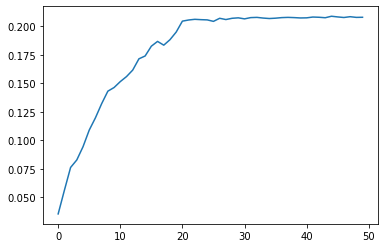

In [7]:
plt.plot(np.array(tst_acc_list)[:,0])

In [8]:
# for epoch_ in range(n_epochs, n_epochs + 25):
#     lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
#     for idx, (x, y) in tqdm(enumerate(train_loader)):
#         x, y = x.to(device), y.to(device)
#         x = x.view(x.size(0),-1).T
#         y_one_hot = F.one_hot(y, 10).to(device).T
#         take_debug_logs_ = (idx % 500 == 0)
#         if use_random_sign_beta:
#             rnd_sgn = 2*np.random.randint(2) - 1
#             beta = rnd_sgn*beta
            
#         neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
#                                              lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
#                                              neural_lr_decay_multiplier, neural_dynamic_iterations_free,
#                                              neural_dynamic_iterations_nudged, beta, 
#                                              use_three_phase, take_debug_logs_, weight_decay)
    
#     trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
#                                                     neural_lr_stop, neural_lr_rule, 
#                                                     neural_lr_decay_multiplier, 
#                                                     neural_dynamic_iterations_free, 
#                                                     device, printing = False)
#     tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
#                                                     neural_lr_stop, neural_lr_rule, 
#                                                     neural_lr_decay_multiplier, 
#                                                     neural_dynamic_iterations_free, 
#                                                     device, printing = False)
#     trn_acc_list.append(trn_acc)
#     tst_acc_list.append(tst_acc)
    
#     print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
#     print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
#     print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

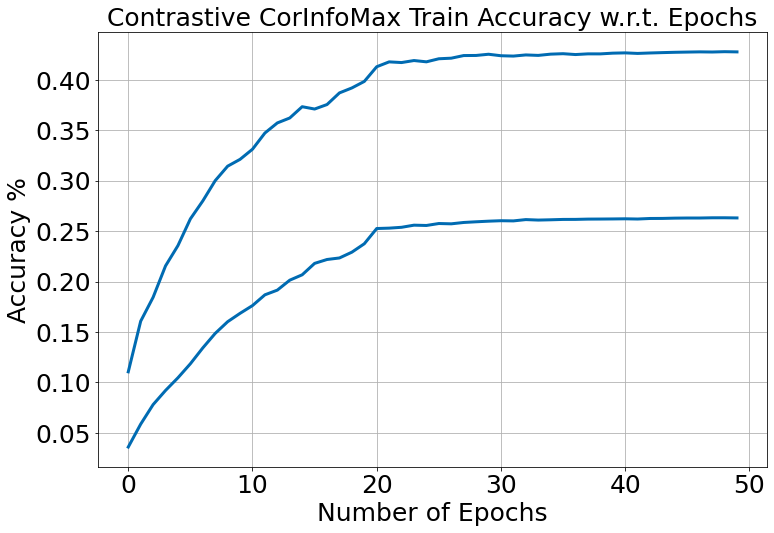

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

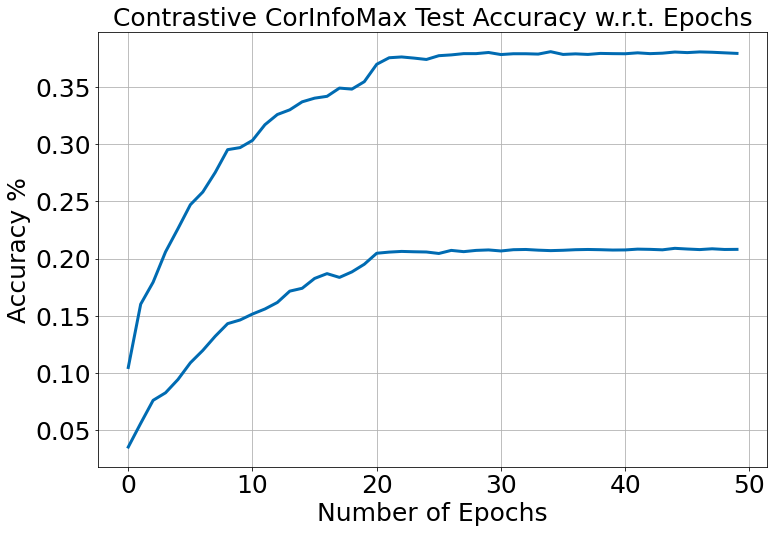

In [10]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

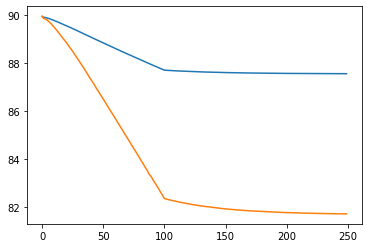

In [11]:
plt.plot(model.forward_backward_angles)

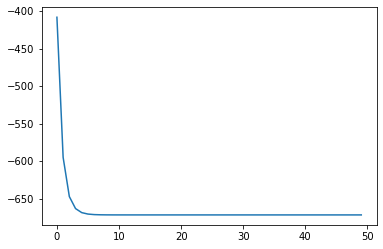

In [12]:
plt.plot((model.neural_dynamics_free_backward_info_list[10]))

In [13]:
x.shape

torch.Size([3072, 20])

In [14]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [15]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [16]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [17]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [18]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])